In [6]:
import pandas as pd
import sqlite3

con = sqlite3.connect("SoccerDataset/database.sqlite")

# Load the data into a DataFrame
inner = 'SELECT player_api_id, MAX(date) as date FROM player_attributes GROUP BY player_api_id'
player_df = pd.read_sql_query('SELECT * from Player p INNER JOIN ('+ inner +') Sub1 ON p.player_api_id = Sub1.player_api_id INNER JOIN player_attributes ON player_attributes.player_api_id = Sub1.player_api_id AND player_attributes.date = Sub1.date', con)

con.close()

In [7]:
player_df

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,505942,2016-02-18 00:00:00,1,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,155782,2016-04-21 00:00:00,6,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,162549,2016-01-07 00:00:00,39,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,30572,2016-04-21 00:00:00,65,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,23780,2015-12-24 00:00:00,88,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168,26357,2015-03-06 00:00:00,183925,...,52.0,50.0,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0
11060,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176,111182,2014-09-18 00:00:00,183938,...,49.0,53.0,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0
11061,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154,36491,2011-02-22 00:00:00,183954,...,66.0,61.0,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0
11062,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172,35506,2011-02-22 00:00:00,183961,...,63.0,45.0,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0


In [92]:
def prepare_dataframe(df):
    df = df[df.defensive_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['defensive_work_rate'], prefix='defensive_work_rate')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['preferred_foot'], prefix='foot')],axis=1)
    df = df[df.attacking_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['attacking_work_rate'], prefix='attacking_work_rate')],axis=1)
    df = df.drop(['defensive_work_rate', 'preferred_foot', 'attacking_work_rate'], axis=1)
    return df

player_df = prepare_dataframe(player_df)

In [93]:
# Ok IDEE: Neue Daten generieren OHNE die Verwendung von GANs. Dazu erstelle ich Buckets (n-Viele) und gebe die percentiles wieder. 

def get_col_quantile(df, col, buckets):
    step = 1 / buckets
    container = []
    
    for i in range(buckets):
        container.append(df[col].quantile(step * i))
    
    return container

quantile = get_col_quantile(player_df, 'overall_rating', 10)
quantile

[47.0, 61.0, 63.0, 65.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0]

In [94]:
print([player_df['overall_rating'].mean(), player_df['overall_rating'].max(), player_df['overall_rating'].min(), player_df['overall_rating'].std()])

[68.27505803976986, 94.0, 47.0, 6.282576855113117]


In [95]:
def split_df_in_buckets(df, col, buckets):
    split = df.shape[0] / buckets
    container = []
    
    for i in range(buckets):
        container.append(df.sort_values(by=[col])[int(i*split):int((i+1)*split)])
        
    return container

In [96]:
buckets = split_df_in_buckets(player_df, 'overall_rating', 10)
buckets[1]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
3023,3027,177843,Enes Sipovic,226628,1990-09-11 00:00:00,198.12,203,177843,2015-05-15 00:00:00,50485,...,11.0,9.0,0,0,1,0,1,0,0,1
9228,9238,301241,Ross Barbour,212907,1993-02-01 00:00:00,177.80,157,301241,2016-03-10 00:00:00,153755,...,16.0,11.0,0,0,1,0,1,0,0,1
1299,1302,89548,Bojan Bozovic,164407,1985-02-03 00:00:00,190.50,185,89548,2015-07-03 00:00:00,22037,...,14.0,13.0,0,0,1,0,1,1,0,0
7391,7401,192679,Michael Tidser,213460,1990-01-15 00:00:00,182.88,168,192679,2015-01-09 00:00:00,123822,...,8.0,13.0,0,0,1,1,0,1,0,0
6849,6858,32658,Mark Brown,45162,1981-02-28 00:00:00,185.42,172,32658,2014-12-05 00:00:00,114391,...,60.0,60.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10966,10978,26674,Youssef El Akchaoui,109809,1981-02-18 00:00:00,175.26,159,26674,2012-08-31 00:00:00,182524,...,10.0,12.0,0,0,1,1,0,0,0,1
9600,9611,68827,Sebastian Ziajka,204145,1982-12-15 00:00:00,182.88,165,68827,2016-05-05 00:00:00,159873,...,15.0,9.0,0,1,0,1,0,1,0,0
992,995,173983,Arthur,192038,1987-01-14 00:00:00,177.80,150,173983,2016-03-24 00:00:00,17121,...,6.0,13.0,0,0,1,1,0,1,0,0
9598,9609,299021,Sebastian Steblecki,208907,1992-01-16 00:00:00,185.42,154,299021,2016-03-03 00:00:00,159845,...,7.0,16.0,0,0,1,0,1,1,0,0


In [97]:
for df in buckets:
    print(df['overall_rating'].mean())
    print(df['overall_rating'].std())

57.41818181818182
2.6908211441868066
61.98789101917255
0.7887175962897163
64.0100908173562
0.6371488669161706
65.58484848484848
0.4929971966119816
67.27547931382442
0.508308888956166
68.85671039354187
0.6127046150767197
70.62525252525252
0.591453016089472
72.63471241170535
0.6290652782344168
74.91422805247225
0.795002944191316
79.43188698284561
2.633343377683589


In [98]:
player_df.dtypes

id                              int64
player_api_id                   int64
player_name                    object
player_fifa_api_id              int64
birthday                       object
height                        float64
weight                          int64
player_api_id                   int64
date                           object
id                              int64
player_fifa_api_id              int64
player_api_id                   int64
date                           object
overall_rating                float64
potential                     float64
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed

In [51]:
player_df['defensive_work_rate'].unique()

array(['medium', 'high', '_0', '5', 'low', 'ean', 'o', '1', 'ormal', '7',
       '2', '8', '4', 'tocky', '0', '3', '6', '9', 'es', None],
      dtype=object)

In [52]:
player_df['preferred_foot'].unique()

array(['right', 'left', None], dtype=object)

In [83]:
player_df[player_df.attacking_work_rate == "None"]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
41,42,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,194479,2016-03-24 00:00:00,676,...,71.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
66,67,40938,Abel,17880,1978-12-22 00:00:00,177.80,165,40938,2010-08-30 00:00:00,1046,...,75.0,66.0,73.0,74.0,72.0,7.0,5.0,7.0,13.0,10.0
72,73,80592,Aboubakar Oumarou,218548,1987-04-01 00:00:00,182.88,168,80592,2015-04-01 00:00:00,1129,...,60.0,64.0,23.0,34.0,36.0,9.0,10.0,7.0,11.0,13.0
81,82,45960,Achmed Ahahaoui,171405,1983-12-06 00:00:00,177.80,152,45960,2011-02-22 00:00:00,1273,...,68.0,46.0,33.0,21.0,23.0,7.0,15.0,5.0,8.0,6.0
218,219,120917,Ahmed Kashi,188825,1988-11-18 00:00:00,177.80,168,120917,2016-04-21 00:00:00,3756,...,59.0,52.0,71.0,72.0,69.0,12.0,7.0,13.0,15.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11024,11036,25906,Ze Manuel,139083,1975-02-22 00:00:00,167.64,143,25906,2010-02-22 00:00:00,183445,...,NaN,74.0,41.0,36.0,NaN,8.0,23.0,68.0,23.0,23.0
11026,11038,163939,Ze Mario,190343,1989-07-16 00:00:00,180.34,154,163939,2010-08-30 00:00:00,183462,...,45.0,30.0,60.0,59.0,58.0,9.0,15.0,5.0,7.0,14.0
11031,11043,30850,Zeljko Kalac,51883,1972-12-16 00:00:00,203.20,209,30850,2009-02-22 00:00:00,183536,...,NaN,70.0,20.0,20.0,NaN,75.0,73.0,71.0,73.0,75.0
11032,11044,164093,Zequinha,193482,1987-07-01 00:00:00,182.88,163,164093,2015-10-30 00:00:00,183540,...,65.0,69.0,29.0,38.0,39.0,12.0,12.0,9.0,16.0,8.0


In [76]:
#pd.get_dummies(player_df['preferred_foot'], prefix='foot')
pd.concat([player_df,pd.get_dummies(player_df['preferred_foot'], prefix='foot')],axis=1)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,foot_left,foot_right
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,505942,2016-02-18 00:00:00,1,...,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,0,1
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,155782,2016-04-21 00:00:00,6,...,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,1,0
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,162549,2016-01-07 00:00:00,39,...,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0,0,1
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,30572,2016-04-21 00:00:00,65,...,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,0,1
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,23780,2015-12-24 00:00:00,88,...,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168,26357,2015-03-06 00:00:00,183925,...,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0,0,1
11060,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176,111182,2014-09-18 00:00:00,183938,...,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0,1,0
11061,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154,36491,2011-02-22 00:00:00,183954,...,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0,1,0
11062,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172,35506,2011-02-22 00:00:00,183961,...,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0,0,1


In [223]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors
import pandas as pd
#referring to https://stats.stackexchange.com/questions/215938/generate-synthetic-data-to-match-sample-data

df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
column_names = list(df.columns)

def SMOTE(T, N, k):
# """
# Returns (N/100) * n_minority_samples synthetic minority samples.
#
# Parameters
# ----------
# T : array-like, shape = [n_minority_samples, n_features]
#     Holds the minority samples
# N : percetange of new synthetic samples:
#     n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
# k : int. Number of nearest neighbours.
#
# Returns
# -------
# S : array, shape = [(N/100) * n_minority_samples, n_features]
# """
    n_minority_samples, n_features = T.shape

    if N < 100:
       #create synthetic samples only for a subset of T.
       #TODO: select random minortiy samples
       N = 100
       pass

    if (N % 100) != 0:
       raise ValueError("N must be < 100 or multiple of 100")

    N = N/100
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    n_features = int(n_features)
    S = np.zeros(shape=(n_synthetic_samples, n_features))

    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

    #Calculate synthetic samples
    for i in range(n_minority_samples):
        nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
        for n in range(int(N)):
            nn_index = choice(nn[0]) #Take one of the nearest neighbour
            #NOTE: nn includes T[i], we don't want to select it
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i] # calculates the difference between current and neighbour
            gap = np.random.random() # bring some randomness to the mix
            S[int(n + i * N), :] = T[i,:] + gap * dif[:] # set the new data
    return S

df = df.to_numpy()
new_data = SMOTE(df,1000,10) # this is where I call the function and expect new_data to be generated with larger number of samples than original df.
new_data.shape

(99070, 43)

In [224]:
new_df = pd.DataFrame(new_data, columns=column_names)

In [225]:
def compare_two_dataframe(df1, df2, col_names, buckets = 10):
    res = []
    dif_total = 0
    
    for col in col_names:
        q1 = get_col_quantile(df1, col, buckets)
        q2 = get_col_quantile(df2, col, buckets)
        
        dif = []
        for i in range(buckets):
            dif.append(q1[i] - q2[i])
            
        percent = 1
        if sum(q1) > sum(q2):
            percent = sum(q2) / sum(q1)
        elif sum(q1) < sum(q2):
            percent = sum(q1) / sum(q2)
            
        dif_total += sum(dif)
        entry = {
            'name': col,
            'q1': q1,
            'q2': q2,
            'dif': dif,
            'dif_total': sum(dif),
            'percent': percent,
        }
        #res.append(entry)
        res.append(percent)
        
    return (res, dif_total)

In [232]:
res, dif_total = compare_two_dataframe(new_df, player_df, column_names, 100)
dif_total

126.8692489589857

In [233]:
import matplotlib.pyplot as plt

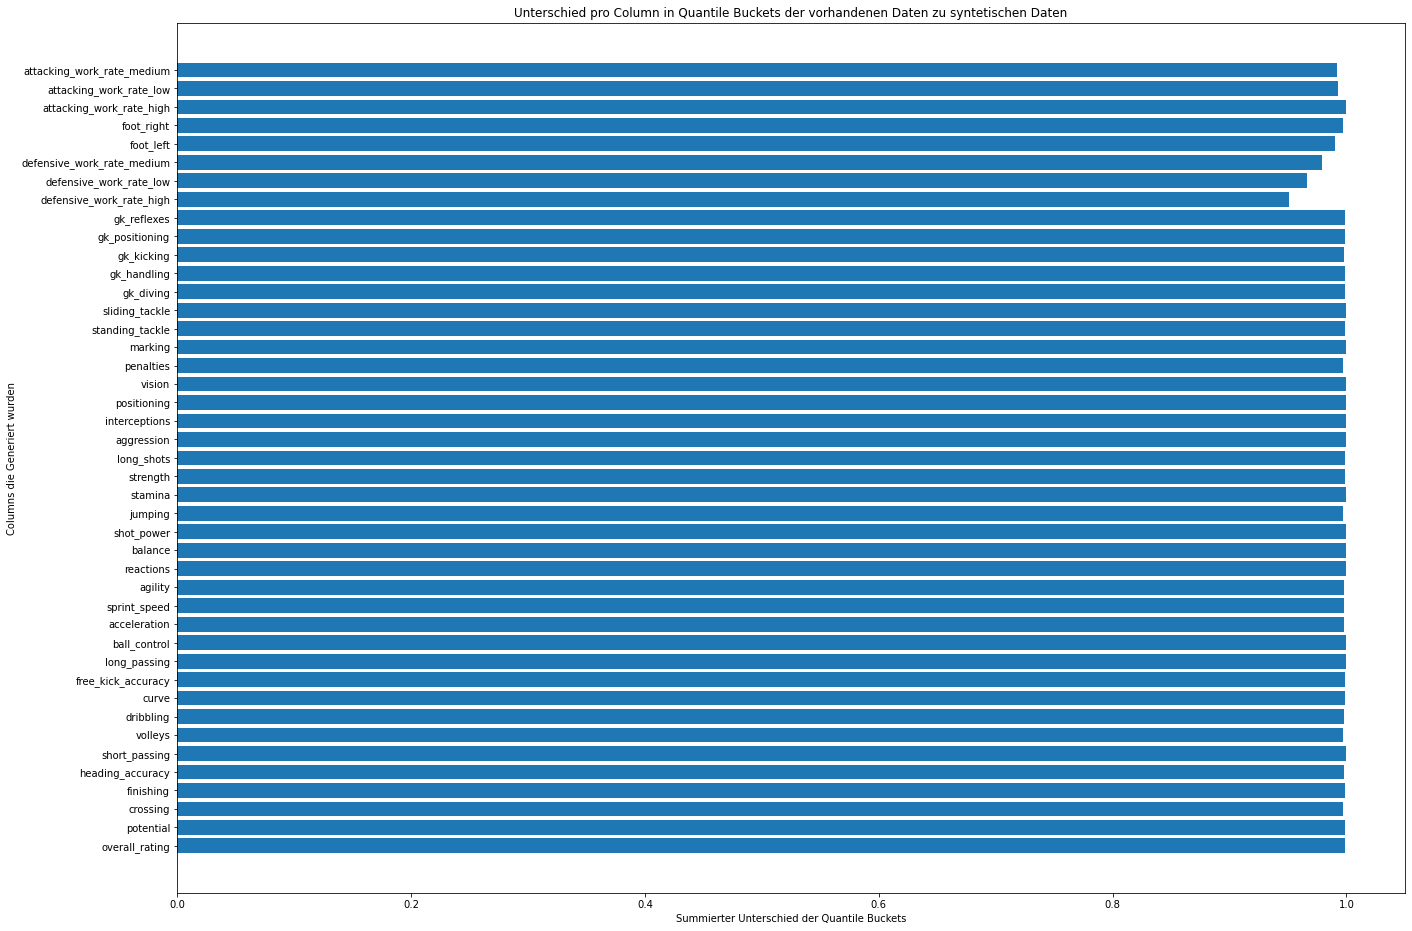

In [234]:
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [235]:
print(f'Overall accuracy: {sum(res) / len(res)}')

Overall accuracy: 0.9959507312850683


In [236]:
new_df[new_df.overall_rating > 85]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
4531,85.279257,86.759752,77.120124,82.759752,65.480495,79.240248,76.798762,87.039009,78.120124,77.759752,...,11.399381,12.879876,1.000000,0.000000,0.000000,0.120124,0.879876,1.000000,0.0,0.000000
4533,85.134365,87.000000,74.980185,83.865635,68.173995,79.288545,79.154180,87.134365,76.845820,76.557275,...,9.980185,10.980185,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000
4537,85.837219,87.000000,76.620178,83.162781,65.596863,79.054260,78.217041,87.837219,77.782959,77.728698,...,11.620178,12.620178,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000
5587,85.895666,86.895666,61.895666,59.958266,70.187801,88.937400,44.062600,73.874799,66.062600,67.979133,...,8.958266,12.916533,0.000000,0.000000,1.000000,0.000000,1.000000,0.020867,0.0,0.979133
6792,86.188069,86.188069,77.458713,69.511460,55.000000,85.864678,74.188069,85.323391,77.782104,76.188069,...,13.594035,9.135322,0.135322,0.000000,0.864678,0.135322,0.864678,1.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98914,86.241294,86.241294,78.206965,87.241294,71.586070,83.448259,81.516915,85.344776,80.000000,82.206965,...,10.103483,12.000000,0.000000,0.448259,0.551741,0.551741,0.448259,0.551741,0.0,0.448259
98915,85.429709,85.429709,78.856233,86.429709,70.287534,83.285942,78.432893,84.857825,80.000000,82.856233,...,10.428117,12.000000,0.000000,0.285942,0.714058,0.714058,0.285942,0.714058,0.0,0.285942
98917,85.739856,85.739856,78.608115,86.739856,70.783769,83.347971,79.611452,85.043914,80.000000,82.608115,...,10.304058,12.000000,0.000000,0.347971,0.652029,0.652029,0.347971,0.652029,0.0,0.347971
98918,86.650127,86.650127,74.825064,88.237595,77.468671,80.475191,89.062659,83.475191,78.825064,76.768925,...,9.587468,11.706266,0.000000,0.706266,0.293734,0.000000,1.000000,0.000000,0.0,1.000000


In [237]:
df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
df[df.overall_rating > 85]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
498,86.0,87.0,77.0,83.0,65.0,79.0,78.0,88.0,78.0,78.0,...,12.0,13.0,1,0,0,0,1,1,0,0
739,88.0,88.0,79.0,73.0,54.0,92.0,74.0,90.0,80.0,70.0,...,13.0,7.0,0,0,1,0,1,1,0,0
794,86.0,86.0,90.0,75.0,53.0,81.0,77.0,87.0,83.0,72.0,...,12.0,11.0,0,0,1,1,0,1,0,0
948,89.0,89.0,80.0,85.0,51.0,85.0,86.0,93.0,86.0,83.0,...,5.0,15.0,0,1,0,1,0,1,0,0
1642,86.0,86.0,86.0,76.0,74.0,92.0,81.0,81.0,77.0,81.0,...,15.0,15.0,0,0,1,0,1,1,0,0
1992,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,77.0,...,14.0,11.0,0,1,0,0,1,1,0,0
2337,87.0,90.0,17.0,13.0,21.0,31.0,13.0,13.0,21.0,19.0,...,85.0,89.0,0,0,1,0,1,0,0,1
2410,86.0,86.0,85.0,72.0,54.0,92.0,80.0,87.0,83.0,77.0,...,1.0,1.0,0,1,0,1,0,1,0,0
2624,86.0,86.0,55.0,42.0,92.0,77.0,47.0,53.0,49.0,51.0,...,5.0,15.0,1,0,0,0,1,0,0,1
2835,88.0,90.0,80.0,81.0,57.0,85.0,79.0,94.0,82.0,79.0,...,8.0,8.0,0,0,1,0,1,1,0,0
